<a href="https://colab.research.google.com/github/Rominaarab/Machine-learning/blob/main/radiology_MOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Business Scenario: Deep Learning Pipeline for Histopathological Cancer Image Classification**

## **Introduction & Business Relevance**
Cancer is a major global death cause, and early, accurate diagnosis is important for existence. Histopathological imaging is the standard of gold, but it is prone to subjective, time-intensity and variability. A deep learning-based classification pipeline automatically automatically detects lungs and colon cancer using high-resolution histopathological images, enabling rapid pathology workflows and increases clinical stability in high-scriptures.

The pipeline uses histopathological data for immediate diagnostics, reducing the burden on pathologists by pre-screening or auto-labeling images. It also improves diagnostic services' scalability in under-resourced or overburdened clinical settings. Convolutional neural networks (CNNs) are chosen due to their proven efficacy in medical imaging computer vision tasks.

**Methods**

* *Data Augmentation:* To address class imbalance and improve generalization.

* *Transfer Learning:* Leveraging pre-trained CNN architectures like ResNet, VGG, or EfficientNet to avoid training from scratch and gain performance with limited GPU resources.

* *Batch Normalization & Dropout:* For stabilizing training and reducing overfitting.

* *Softmax Activation:* For multi-class cancer subtype prediction.

* *Evaluation Metrics:* Accuracy, F1-score, and confusion matrix analysis ensure robust model assessment across all classes.

**The main dataset contains** 25,000 histopathological images with 5 classes includes two different cancer lung and colon tissue. All images are 768 x 768 pixels in size and are in jpeg file format.
There are five classes in the dataset, each with 5,000 images, being. I worked on lung cancer which consists of three classes:

* Lung benign tissue
* Lung adenocarcinoma
* Lung squamous cell carcinoma

Reference:
https://arxiv.org/abs/1912.12142v1

## **Importing libraries**

In [ ]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,classification_report
import keras as k
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dense,Dropout,BatchNormalization,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

## **🏗️ Data Acquisition**

In [ ]:
zip_path = '/content/Lung R.zip'
extract_path = '/content/extracted_slides'

**I should unpack it and put it in a directory called: extracted slides.**

In [ ]:
os.makedirs(extract_path, exist_ok=True)

In [ ]:
print(f"Attempting to unzip {zip_path} to {extract_path}...")
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Unzipping complete.")
except zipfile.BadZipFile:
    print(f"Error: '{zip_path}' is still not a valid zip file. It might be corrupted or incomplete.")
except FileNotFoundError:
    print(f"Error: '{zip_path}' not found. Make sure you downloaded it correctly.")
except Exception as e:
    print(f"An unexpected error occurred during unzipping: {e}")

Attempting to unzip /content/Lung R.zip to /content/extracted_slides...
Unzipping complete.


**reading image data:**

In [ ]:
data_root_dir = '/content/extracted_slides'

In [ ]:
image_paths = []
image_labels = []


for class_name in os.listdir(data_root_dir):
    class_dir = os.path.join(data_root_dir, class_name)

    if os.path.isdir(class_dir):
        for image_filename in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_filename)
            if os.path.isfile(image_path) and image_filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                image_paths.append(image_path)
                image_labels.append(class_name)

In [ ]:
df = pd.DataFrame({
    'image_path': image_paths,
    'label': image_labels
})

In [ ]:
df.head()

,image_path,label
0,/content/extracted_slides/Lung_sccR/lungscc181...,Lung_sccR
1,/content/extracted_slides/Lung_sccR/lungscc209...,Lung_sccR
2,/content/extracted_slides/Lung_sccR/lungscc777...,Lung_sccR
3,/content/extracted_slides/Lung_sccR/lungscc105...,Lung_sccR
4,/content/extracted_slides/Lung_sccR/lungscc123...,Lung_sccR


**Sample Images from Dataset**


--- Sample Images from Dataset ---


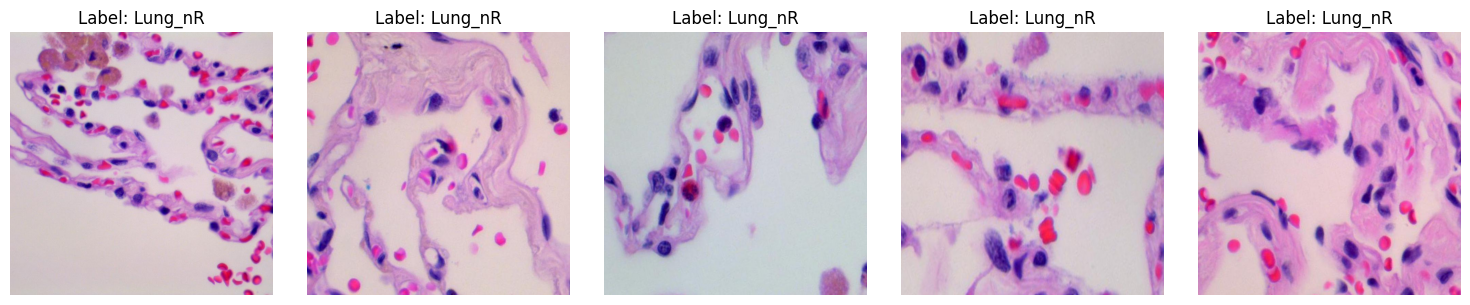

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
sample_df = df.sample(n=5, random_state=42) # Get 5 random images

for i, (idx, row) in enumerate(sample_df.iterrows()):
    img_path = row['image_path']
    label = row['label']
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

**Exploring in the dataset.**

In [ ]:
df.isnull().sum()

,0
image_path,0
label,0


## **Spliting the data into test and train:**

In [ ]:
X = df['image_path']
y = df['label']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.10, random_state=42)

**I made a class to load images from the paths in DataFrame.**

I get get image path and label from the DataFrame. then load the image and converted imgae lables into numerical ID.

In [ ]:
class Standard_Image_Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.unique_labels = sorted(self.dataframe['label'].unique().tolist())
        self.label_map = {label: i for i, label in enumerate(self.unique_labels)}
        self.num_classes = len(self.unique_labels)
        print(f"Detected classes: {self.unique_labels}")
        print(f"Label to ID mapping: {self.label_map}")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label_text = self.dataframe.iloc[idx]['label']

        image = Image.open(img_path).convert("RGB")

        numerical_label = self.label_map[label_text]

        if self.transform:
            image = self.transform(image)

        return image, numerical_label

**I am splitting data into training, validation, and test sets**

Because I am classifying by 'label', so it is crucial to be ensure having a balanced distribution of classes in splits.

In [ ]:
X = df['image_path']
y = df['label']

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.10, random_state=42, stratify=y_train_val
)

train_df = pd.DataFrame({'image_path': X_train, 'label': y_train}).reset_index(drop=True)
val_df = pd.DataFrame({'image_path': X_val, 'label': y_val}).reset_index(drop=True)
test_df = pd.DataFrame({'image_path': X_test, 'label': y_test}).reset_index(drop=True)

In [ ]:
print(f"\nTotal images: {len(df)}")
print(f"Training images: {len(train_df)}")
print(f"Validation images: {len(val_df)}")
print(f"Test images: {len(test_df)}")

print("\nTraining set label distribution:")
print(train_df['label'].value_counts(normalize=True))
print("\nValidation set label distribution:")
print(val_df['label'].value_counts(normalize=True))
print("\nTest set label distribution:")
print(test_df['label'].value_counts(normalize=True))


Total images: 6556
Training images: 5014
Validation images: 558
Test images: 984

Training set label distribution:
label
Lung_nR      0.368767
Lung_sccR    0.362385
Lung_acaR    0.268847
Name: proportion, dtype: float64

Validation set label distribution:
label
Lung_nR      0.369176
Lung_sccR    0.362007
Lung_acaR    0.268817
Name: proportion, dtype: float64

Test set label distribution:
label
Lung_nR      0.368902
Lung_sccR    0.362805
Lung_acaR    0.268293
Name: proportion, dtype: float64


## **Data Preprocessing**

**Preproccessing step includes incorporating data augmentation for generalization and resizing and center-cropping for consistency. All images are normalized using ImageNet statistics to match pre-trained models like ResNet. All images are normalized using ImageNet statistics to match pre-trained models like ResNet.**

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

**Creating train, validation and test dataset.**

In [ ]:
train_dataset = Standard_Image_Dataset(train_df, train_transform)
val_dataset = Standard_Image_Dataset(val_df, val_test_transform)
test_dataset = Standard_Image_Dataset(test_df, val_test_transform)

Detected classes: ['Lung_acaR', 'Lung_nR', 'Lung_sccR']
Label to ID mapping: {'Lung_acaR': 0, 'Lung_nR': 1, 'Lung_sccR': 2}
Detected classes: ['Lung_acaR', 'Lung_nR', 'Lung_sccR']
Label to ID mapping: {'Lung_acaR': 0, 'Lung_nR': 1, 'Lung_sccR': 2}
Detected classes: ['Lung_acaR', 'Lung_nR', 'Lung_sccR']
Label to ID mapping: {'Lung_acaR': 0, 'Lung_nR': 1, 'Lung_sccR': 2}


In [ ]:
num_classes = train_dataset.num_classes

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
print(f"\nNumber of classes for the model: {num_classes}")


Number of classes for the model: 3


# **Model pretraing**

In [ ]:
#ResNet model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]


In [ ]:
model.fc = nn.Linear(num_ftrs, num_classes)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# **Training and Evaluationing the model**
Now I will train and evaluate an intensive teaching model on many ages. During each era, it updates the model using the training set and evaluates its performance on the verification set. The model with the highest verification accuracy is saved as the best model to avoid overfiting and ensure good generalization.

training transform includes data augmentation (random crop, flips, color jitter)  to improve generalization.

validation/testing transforms only resize and center-crop images for consistency.

In [ ]:
num_epochs = 10

print("\nStarting Training...")
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_train
    epoch_acc = correct_train / total_train
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / total_val
    val_acc = correct_val / total_val
    print(f"  Validation Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("  Saved best model with accuracy:", best_val_accuracy)

print("\nTraining Finished.")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")


Starting Training...
Epoch 1/10
  Train Loss: 0.3838, Train Acc: 0.8488
  Validation Loss: 0.3392, Val Acc: 0.8513
  Saved best model with accuracy: 0.8512544802867383
Epoch 2/10
  Train Loss: 0.2874, Train Acc: 0.8843
  Validation Loss: 0.1348, Val Acc: 0.9570
  Saved best model with accuracy: 0.956989247311828
Epoch 3/10
  Train Loss: 0.2275, Train Acc: 0.9124
  Validation Loss: 0.8497, Val Acc: 0.8244
Epoch 4/10
  Train Loss: 0.2104, Train Acc: 0.9170
  Validation Loss: 0.1475, Val Acc: 0.9462
Epoch 5/10
  Train Loss: 0.2095, Train Acc: 0.9154
  Validation Loss: 0.1312, Val Acc: 0.9552
Epoch 6/10
  Train Loss: 0.2557, Train Acc: 0.9033
  Validation Loss: 0.3172, Val Acc: 0.8692
Epoch 7/10
  Train Loss: 0.2229, Train Acc: 0.9107
  Validation Loss: 0.1063, Val Acc: 0.9588
  Saved best model with accuracy: 0.9587813620071685
Epoch 8/10
  Train Loss: 0.1932, Train Acc: 0.9242
  Validation Loss: 0.1016, Val Acc: 0.9606
  Saved best model with accuracy: 0.9605734767025089
Epoch 9/10
  Tr

I run Evaluation on Test set.

In [ ]:
model.eval()
all_preds = []
all_labels = []
all_probs = []


--- Running Evaluation on Test Set ---


**By this code, I am choosing the best model.**

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

In [ ]:
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# **Conclusional Result and Metrics**

In [ ]:
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Overall Test Accuracy: {test_accuracy:.4f}")

Overall Test Accuracy: 0.9573


**I used 'weighted' average for multi-class**

In [ ]:
test_precision = precision_score(all_labels, all_preds, average='weighted')
test_recall = recall_score(all_labels, all_preds, average='weighted')
test_f1 = f1_score(all_labels, all_preds, average='weighted')

In [ ]:
print(f"Test Precision (weighted): {test_precision:.4f}")
print(f"Test Recall (weighted): {test_recall:.4f}")
print(f"Test F1-Score (weighted): {test_f1:.4f}")

Test Precision (weighted): 0.9577
Test Recall (weighted): 0.9573
Test F1-Score (weighted): 0.9575


In [ ]:
test_roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')
print(f"Test ROC AUC (weighted, One-vs-Rest): {test_roc_auc:.4f}")

Test ROC AUC (weighted, One-vs-Rest): 0.9966


In [ ]:
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[244   0  20]
 [  5 358   0]
 [ 17   0 340]]


**Confusion matrix plot**

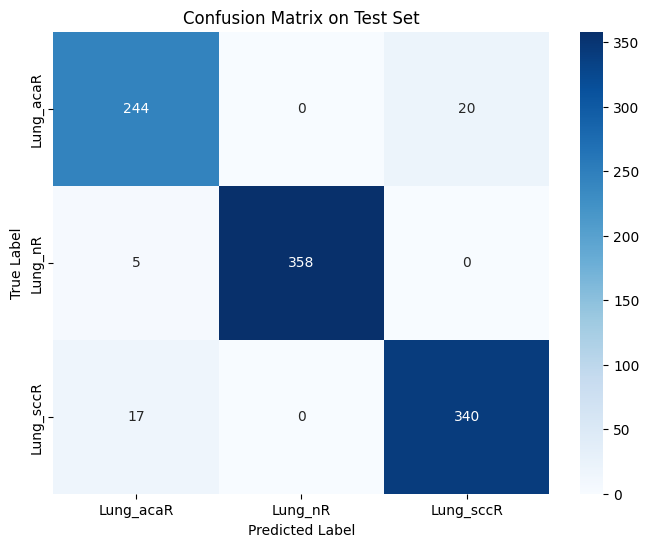

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.unique_labels,
            yticklabels=train_dataset.unique_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()

In [ ]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.unique_labels))


Classification Report:
              precision    recall  f1-score   support

   Lung_acaR       0.92      0.92      0.92       264
     Lung_nR       1.00      0.99      0.99       363
   Lung_sccR       0.94      0.95      0.95       357

    accuracy                           0.96       984
   macro avg       0.95      0.95      0.95       984
weighted avg       0.96      0.96      0.96       984



# **Conclusion**

The Convolutional Neural Network model, leveraging a pre-trained ResNet50, was trained and evaluated on the 'Lung and Colon Cancer Histopathological Images' dataset for multi-class classification.
The dataset consists of 6556 pre-extracted image patches across 3 classes: ['Lung_acaR', 'Lung_nR', 'Lung_sccR'].
The images were split into training, validation, and test sets using stratified sampling to maintain class distribution, ensuring the model's ability to generalize to unseen data.
After 10 epochs of training, the model achieved the following key performance metrics on the independent test set:
- Overall Accuracy: 0.9573
- Weighted Precision: 0.9577
- Weighted Recall: 0.9573
- Weighted F1-Score: 0.9575
- Weighted ROC AUC (One-vs-Rest): 0.9966

These results indicate that the model is capable of distinguishing between the different lung and colon tissue types (normal, adenocarcinoma, squamous cell carcinoma) with good accuracy and discriminative power. The confusion matrix and classification report provide further insights into per-class performance, highlighting areas where the model performs well or struggles with specific class distinctions.
Further potential improvements could involve extensive hyperparameter tuning, exploring more advanced data augmentation techniques, using different CNN architectures (e.g., EfficientNet, Vision Transformers), or implementing class weighting for imbalanced classes if necessary.

Regards,

Romina arab

GH1042522

In [ ]:
from google.colab import files
f = files.upload()

Saving radiology_MOP.ipynb to radiology_MOP.ipynb


In [ ]:
# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

In [ ]:
# download the html
files.download(file0[:-5]+"html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>